In [2]:
## Library 
import pandas as pd
import numpy as np
import scipy as scipy
from scipy import spatial
import json
import argparse
from argparse import Namespace
import glob
from mpl_toolkits.mplot3d import Axes3D 

import sklearn as sk
from sklearn import model_selection
from sklearn import metrics
from scipy.ndimage import gaussian_filter1d
import cv2 as cv2

import matplotlib.pyplot as plt 
import time
import os
import datetime
import tensorflow as tf
import tensorflow.keras as keras
from matplotlib import cm
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import tensorflow.keras as keras

## Utils function from https://github.com/ChrisWu1997/2D-Motion-Retargeting
from functional.visualization import motion2video, hex2rgb
from functional.motion import preprocess_motion2d, postprocess_motion2d, openpose2motion
from functional.utils import ensure_dir, pad_to_height
from model import get_autoencoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from common import config
from dataset import get_meanpose
print(tf.__version__)

2.4.1


In [4]:
connect_dict=[[0,1],[1,2],[2,3],[3,4],[4,5],[3,6],[6,7],[7,8],[8,9],[3,10],[10,11],[11,12],[12,13],[0,14],[14,15],[15,16],[16,17],[0,18],[18,19],[19,20],[20,21]]
pose_net_joint=[4,7,8,9,11,12,13,14,15,16,18,19,20]
open_pose_joint=[4,2,11,12,13,7,8,9,0,18,19,20,14,15,16]
win_size=18
output_dir='inc_deep_squat'
task_list=['m01','m02','m03','m04','m05','m06','m07','m08','m09','m10']
s_number=['s01','s02','s03','s04','s05','s06','s07','s08','s09','s10']
e_number=['e01','e02','e03','e04','e05','e06','e07','e08','e09','e10']
name_dict={'m01':'deep squat','m02':'hurdle step','m03':'inline lunge','m04':'side lunge','m05':'sit to stand','m06':'leg raise','m07':	'shoulder abduction','m08':	'shoulder extension','m09':	'shoulder internal-external rotation','m10':'shoulder scaption'}
LR_table=pd.read_csv('LR_table.csv',index_col=0)
kin_position_path='Segmented Movements/Segmented Movements/Kinect/Positions/'
kin_angle_path='Segmented Movements/Segmented Movements/Kinect/Angles'
perfor=pd.DataFrame(columns=task_list,index=s_number)

def to_3D_corrd_in_view(kinect_postion,kinect_angle):
    kinect_postion=np.array(kinect_postion)
    kinect_angle=np.array(kinect_angle)
    kinect_postion=kinect_postion.reshape(22,3)
    kinect_angle=kinect_angle.reshape(22,3)
    for j_p, j_c in connect_dict:
        rot_mat=scipy.spatial.transform.Rotation.from_euler('yxz',kinect_angle[j_p,:3]*np.pi/180).as_matrix()
        kinect_postion[j_c,:]=kinect_postion[j_p,:]+np.matmul(rot_mat,kinect_postion[j_c,:])   
    return kinect_postion

def plot_skelton(dat,**kwargs):

#     plt.annotate('Waist',(dat[0,0],-dat[0,1]))
#     plt.annotate('head',(dat[4,0],-dat[4,1]))
#     plt.annotate('left hand',(dat[9,0],-dat[9,1]))
#     plt.annotate('Right hand',(dat[13,0],-dat[13,1]))
#     plt.annotate('Left leg',(dat[17,0],-dat[17,1]))
    for j1,j2 in connect_dict:
        plt.plot(dat[[j1,j2],0],-dat[[j1,j2],1],**kwargs)
        
def LR_mirror(kinect_postion,percentage,LR_table,motion): 
    for i in range(len(percentage)):
        if LR_table[motion][percentage.tester[i]]:
            kinect_postion[i,:,0]=-kinect_postion[i,:,0]
    return kinect_postion

def poseNet2openPose(kinect_postion):
    chest=np.mean(kinect_postion[:,[1,4],:],axis=1).reshape(-1,1,kinect_postion.shape[2])
    base=np.mean(kinect_postion[:,[7,10],:],axis=1).reshape(-1,1,kinect_postion.shape[2])
    new_openpose=kinect_postion[:,[0],:]

    new_openpose=np.concatenate((new_openpose,chest),axis=1)
    new_openpose=np.concatenate((new_openpose,kinect_postion[:,[4,5,6],:]),axis=1)
    new_openpose=np.concatenate((new_openpose,kinect_postion[:,[1,2,3],:]),axis=1)
    new_openpose=np.concatenate((new_openpose,base),axis=1)
    new_openpose=np.concatenate((new_openpose,kinect_postion[:,[10,11,12],:]),axis=1)
    new_openpose=np.concatenate((new_openpose,kinect_postion[:,[7,8,9],:]),axis=1)
    return new_openpose

def getPoseNet(motion):
    return(motion[:,pose_net_joint,:])
def getOpenPose(motion):
    return(motion[:,open_pose_joint,:])
def to_2D(motion):
    return(motion[:,:,:2])

def tl_preprocess_encode(motion,encoder,scale=1.2):
    
    motion=to_2D(motion)

    if motion.shape[1] == 22:
        motion=getOpenPose(motion)
    elif motion.shape[1] == 13:
        motion=poseNet2openPose(motion)
    elif motion.shape[1] == 15:
        motion=motion
    else:
        "Not supported skeleton"
    for i in range(len(motion) - 1, 0, -1):
        motion[i - 1][np.where(motion[i - 1] == 0)] = motion[i][np.where(motion[i - 1] == 0)]

    motion = np.stack(motion, axis=2)
    motion = gaussian_filter1d(motion, sigma=2, axis=-1)
    motion = motion * scale
    
    motion=preprocess_motion2d(motion, mean_pose, std_pose)
    motion=motion.to(config.device)
    return encoder(motion).cpu().detach().numpy().squeeze()

def get_sliding_wins(motion,percentage,win_size):
    percentage.reset_index(inplace=True,drop=True)
    sliding_win=[]
    sliding_percent=[]

    for i in percentage.tester.unique():
        print(i)
        start_id=np.where(percentage.tester == i)[0][0]
        end_id=np.where(percentage.tester == i)[0][-1]+1
        for window in percentage.percentage.iloc[start_id:end_id].rolling(window=win_size,min_periods=win_size):
            if len(window)<win_size:
                continue
            else:
                sliding_win.append(motion[window.index,:,:])
                sliding_percent.append(window.iloc[-1])
    sliding_percent=np.array(sliding_percent)
    return(sliding_win,sliding_percent)

In [5]:
def camera_projet(skeleton,rotate,translation):
    rect, pts= cv2.projectPoints(skeleton,rotate,translation,np.identity(3),distCoeffs=None)
    return(rect.squeeze())

def label_encoding(data, segment,win_size,encoder):
    sliding_win, sliding_percent=get_sliding_wins(data, segment,win_size)
    encode_test=[]
    for i in range(len(sliding_win)):
        data=tl_preprocess_encode(sliding_win[i],encoder=encoder)
        encode_test.append(data)
    encode_test=np.array(encode_test)
    return((encode_test,sliding_percent)) 

In [6]:
task= 'm10'
m_data=np.load('data/'+task+'.npy')
percentage=pd.read_csv('data/'+task+'.csv')
m_data=LR_mirror(m_data,percentage,LR_table,task)


In [7]:
np.where(percentage.percentage==0)[0][1]

93

Text(20, -60, 'Frame: 0 \nProgress: 1')

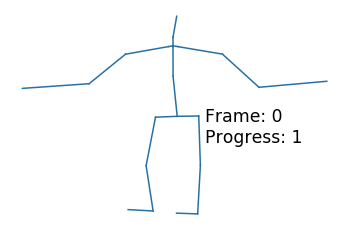

In [8]:
plt.gca().invert_yaxis()
plt.axis('off')
plot_skelton(m_data[np.where(percentage.percentage==1)[0][0]],c='#2670a5')
plt.text(20,-60,"Frame: 0 \nProgress: 1",size='xx-large')

Text(20, -60, 'Frame: 62 \nProgress: 1')

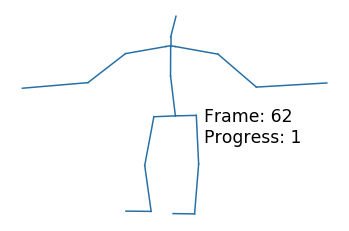

In [9]:
plt.gca().invert_yaxis()
plt.axis('off')
plot_skelton(m_data[np.where(percentage.percentage==1)[0][1]],c='#2670a5')
plt.text(20,-60,"Frame: %s \nProgress: 1"%np.where(percentage.percentage==1)[0][1],size='xx-large')

Text(20, -60, 'Frame: 31 \nProgress: 0.00')

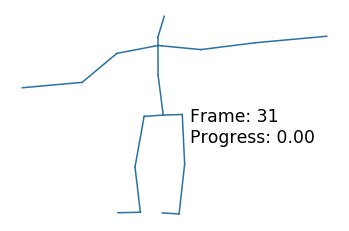

In [10]:
plt.gca().invert_yaxis()
mid_frame=int(np.where(percentage.percentage==1)[0][1]/2+np.where(percentage.percentage==1)[0][0]/2)
plot_skelton(m_data[mid_frame],c='#2670a5')
plt.axis('off')
plt.text(20,-60,"Frame: %s \nProgress: %.2f"%
         (mid_frame,percentage.percentage[mid_frame]),
         size='xx-large')

Text(20, -60, 'Frame: 15 \nProgress: 0.52')

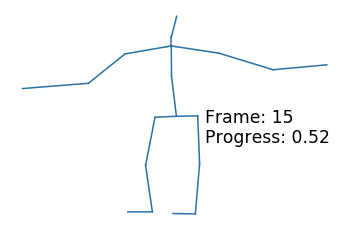

In [11]:
plt.gca().invert_yaxis()
plt.axis('off')
mid_mid_frame=int(mid_frame/2+np.where(percentage.percentage==1)[0][0]/2)
plot_skelton(m_data[mid_mid_frame],c='#2670a5')
plt.text(20,-60,"Frame: %s \nProgress: %.2f"%
         (mid_mid_frame,percentage.percentage[mid_mid_frame]),
         size='xx-large')

Text(20, -60, 'Frame: 46 \nProgress: 0.48')

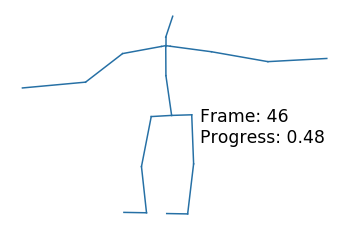

In [12]:
plt.gca().invert_yaxis()
plt.axis('off')
mid_back_frame=int(mid_frame/2+np.where(percentage.percentage==1)[0][1]/2)
plot_skelton(m_data[mid_back_frame],c='#2670a5')
plt.text(20,-60,"Frame: %s \nProgress: %.2f"%
         (mid_back_frame,percentage.percentage[mid_back_frame]),
         size='xx-large')

In [13]:
percentage.percentage[37]

0.1935483870967742

In [14]:
args= argparse.Namespace(name='skeleton',model_path='model/pretrained_skeleton.pth',v1='inc_deep_squat',o='inc_deep_squat',gpu_ids=0,w1=720,h1=720,transparency=False,save_frame=1,
                         fps=25,color1='#a50b69#b73b87#db9dc3',max_len=480,max_frame=480)
config.initialize(args)
mean_pose, std_pose = get_meanpose(config)
net = get_autoencoder(config)
net.load_state_dict(torch.load(args.model_path))
net.to(config.device)
net.eval()
encoder=nn.Sequential(*list(net.mot_encoder.children())[0])

In [15]:
encoder

Sequential(
  (0): ReflectionPad1d((3, 3))
  (1): Conv1d(30, 64, kernel_size=(8,), stride=(2,))
  (2): LeakyReLU(negative_slope=0.2)
  (3): ReflectionPad1d((3, 3))
  (4): Conv1d(64, 96, kernel_size=(8,), stride=(2,))
  (5): LeakyReLU(negative_slope=0.2)
  (6): ReflectionPad1d((3, 3))
  (7): Conv1d(96, 128, kernel_size=(8,), stride=(2,))
  (8): LeakyReLU(negative_slope=0.2)
)

In [16]:
data.shape

NameError: name 'data' is not defined

In [17]:
from scipy import signal
f, t, Sxx  = scipy.signal.spectrogram(sk.preprocessing.MinMaxScaler().fit_transform(sk.metrics.pairwise.cosine_similarity(X_test.reshape((-1,15*3))))[:,1],fs=30)
plt.figure()
plt.pcolormesh(t, f, Sxx, shading='gouraud')

NameError: name 'X_test' is not defined

In [18]:
f

NameError: name 'f' is not defined

In [19]:
start=time.time()
encode_X_test_camera, sim_matrix_X_test_camera =  label_encoding(X_test, y_test,win_size,encoder)
predict=model.predict(encode_X_test_camera)
end=time.time()
print('Inference %s frames, for %s'%(X_test.shape[0],end-start))

NameError: name 'X_test' is not defined

s01


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s02


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s03


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s04


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s05


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s06


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s07


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s08


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s09


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s10


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s01


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s02
s03


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s04


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s05


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s06


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s07


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s08


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s09


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s10


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s01


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s02


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s03


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s04


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s05


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s06


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s07


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s08


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s09


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s10


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s01


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s02


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s03


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s04


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s05


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s06


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s07


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s08


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s09


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s10


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s01


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s02


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s03


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s04


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s05


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s06


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s07


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s08


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s09


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s10


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s01


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s02


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s03


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s04


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s05


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s06


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s07


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s08


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s09


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s10


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s01


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s02


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s03


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s04


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s05


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s06


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s07


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s08


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s09


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s10


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s01


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s02


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s03


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s04


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s05


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s06


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s07


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s08


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s09


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s10


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s01


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s02


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s03


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s04


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s05


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s06


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s07


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s08


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s09


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s10


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s01


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s02


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s03


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s04


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


s05


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s06


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s07


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s08


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s09


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


s10


C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\sdscphd\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


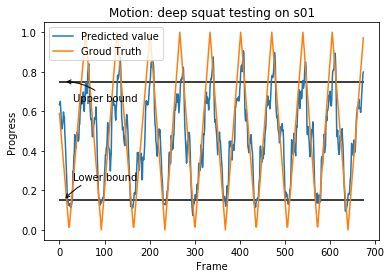

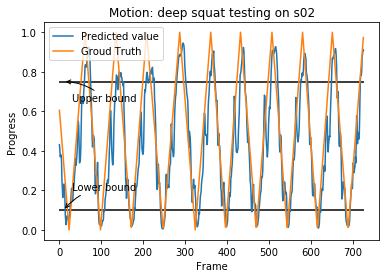

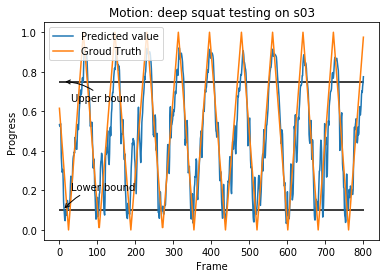

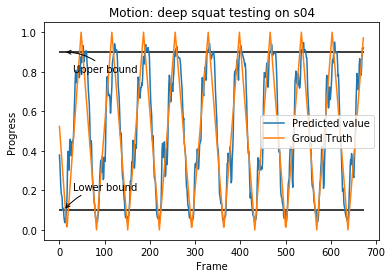

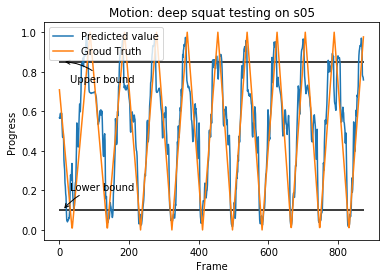

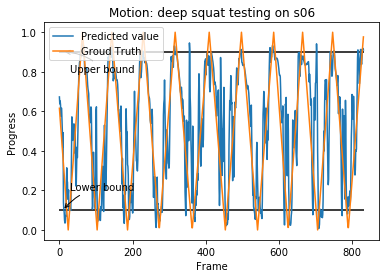

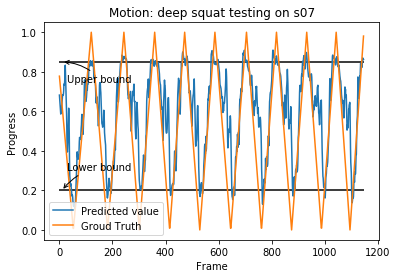

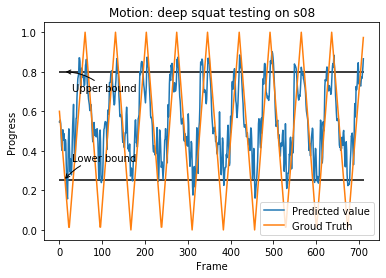

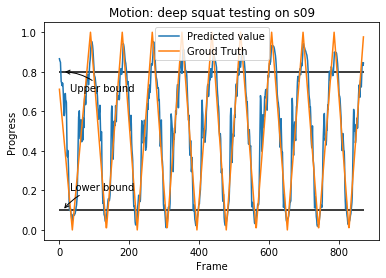

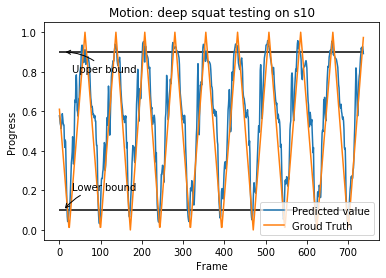

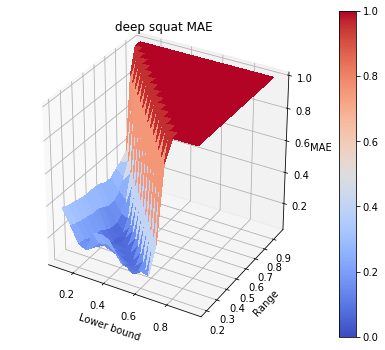

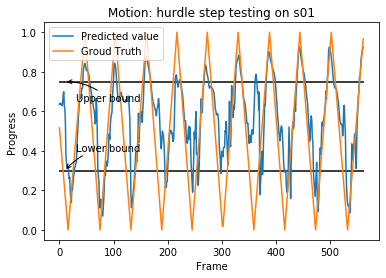

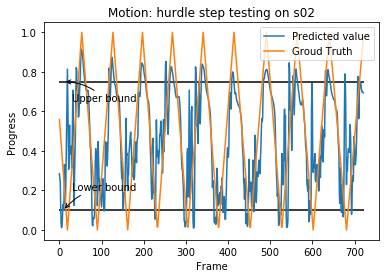

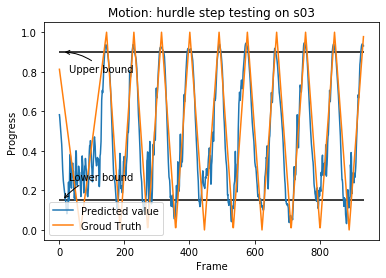

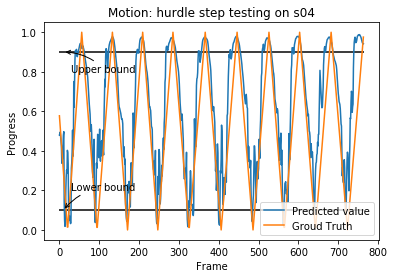

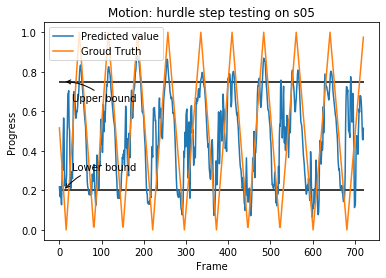

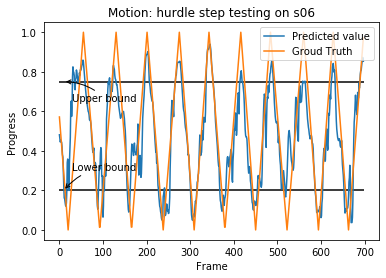

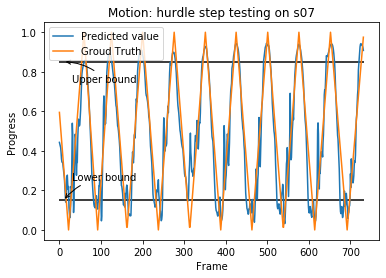

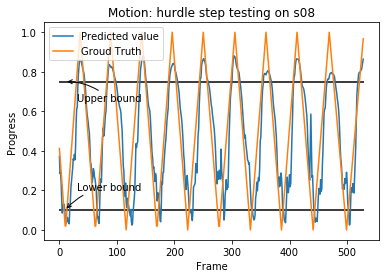

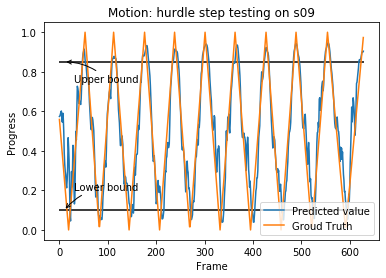

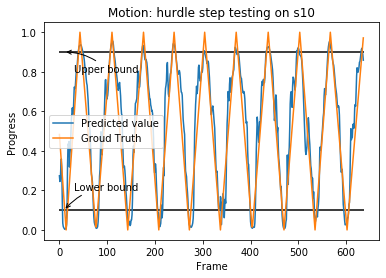

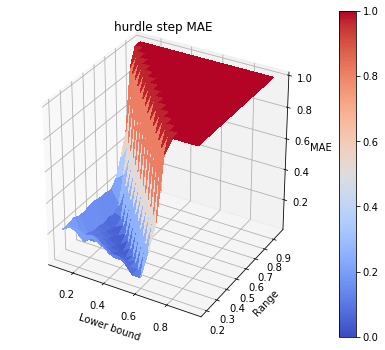

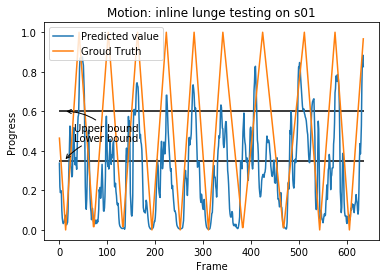

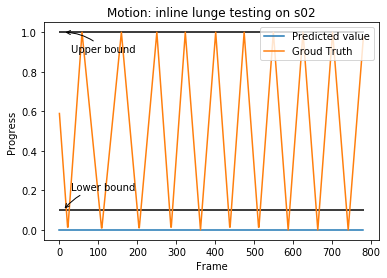

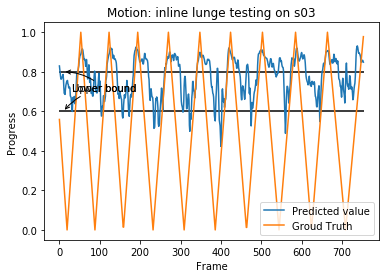

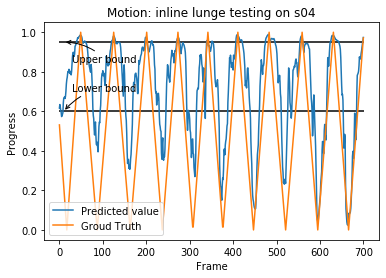

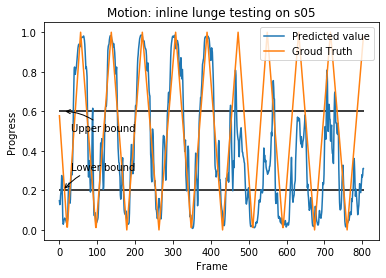

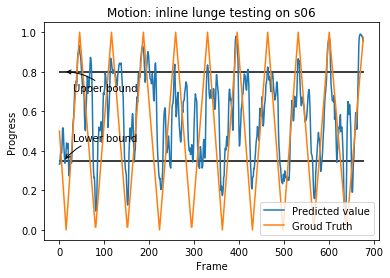

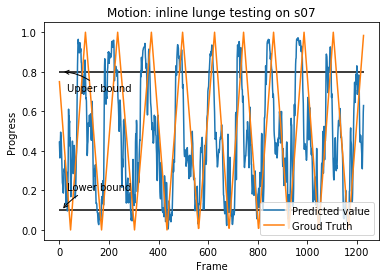

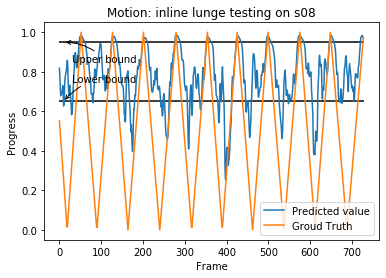

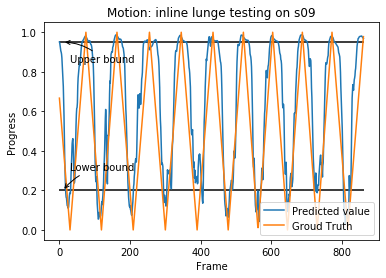

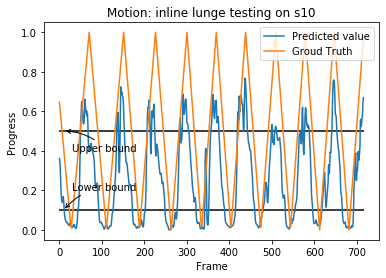

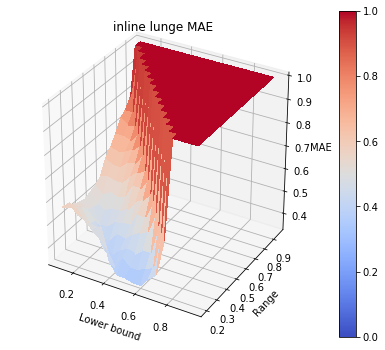

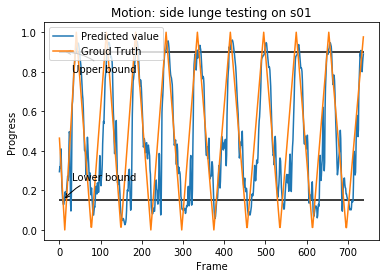

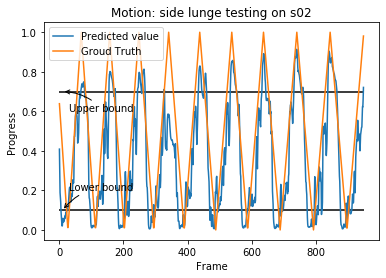

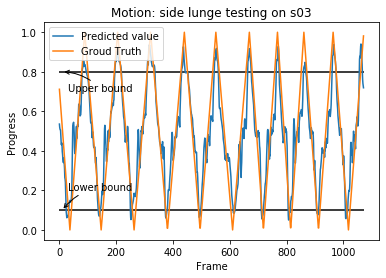

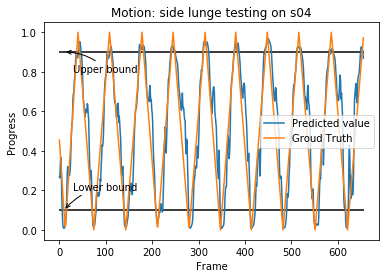

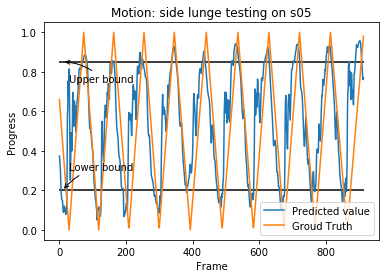

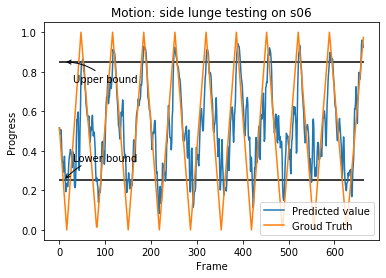

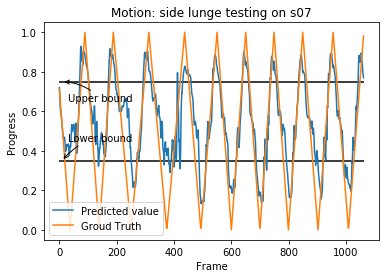

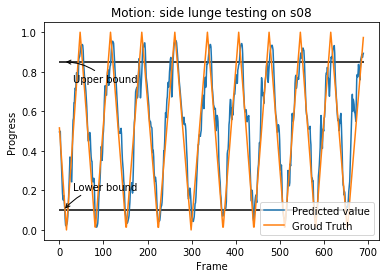

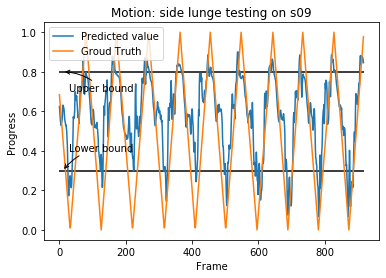

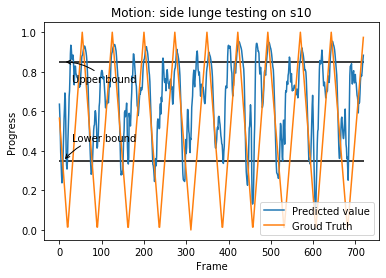

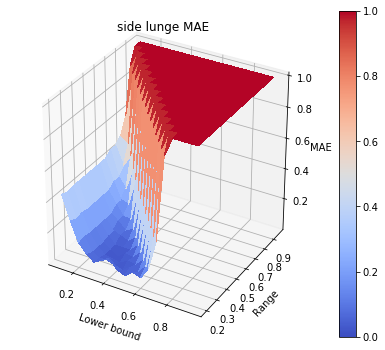

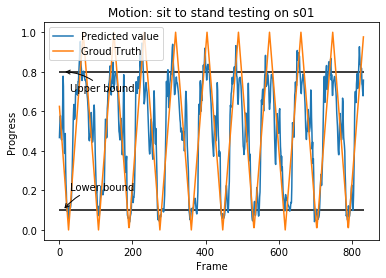

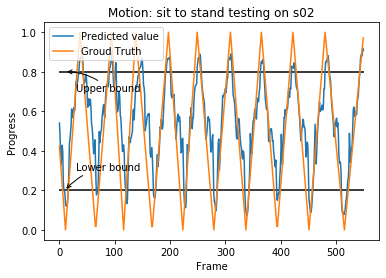

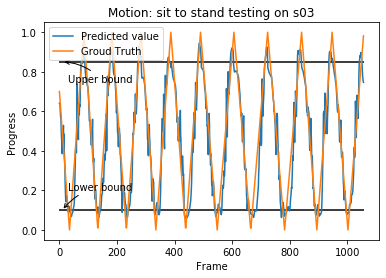

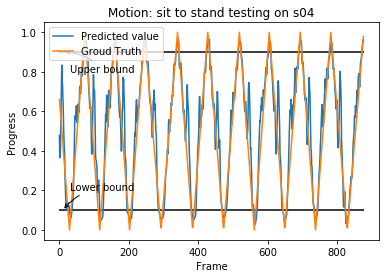

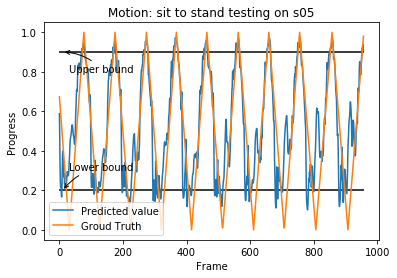

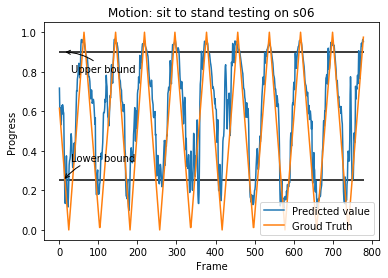

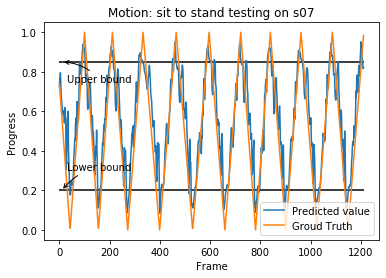

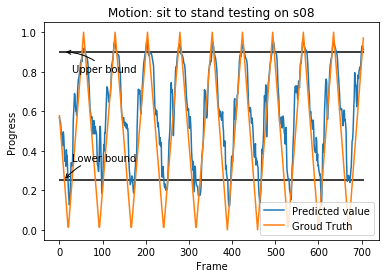

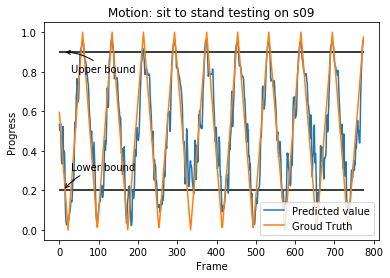

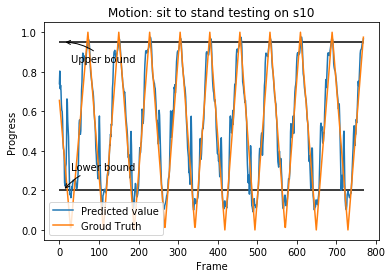

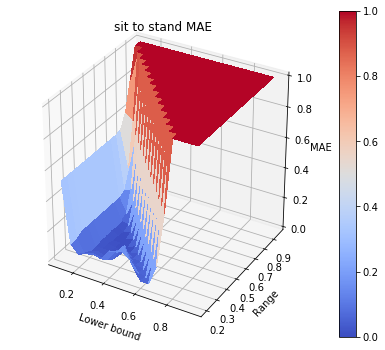

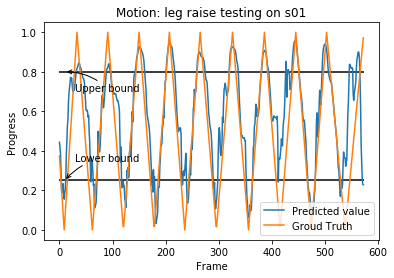

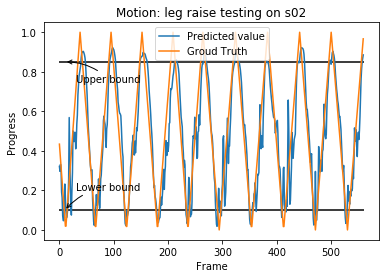

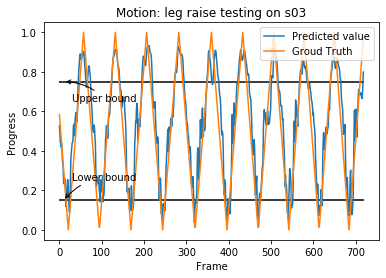

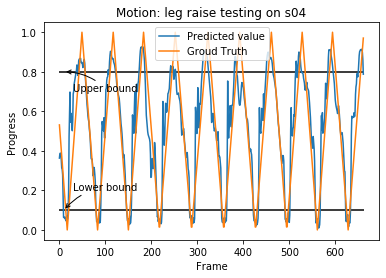

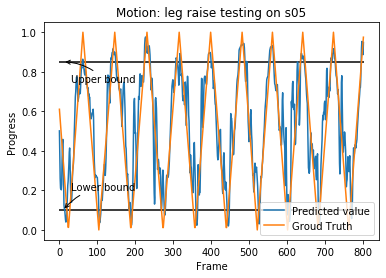

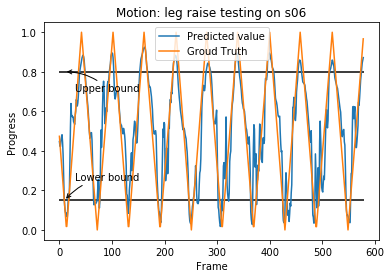

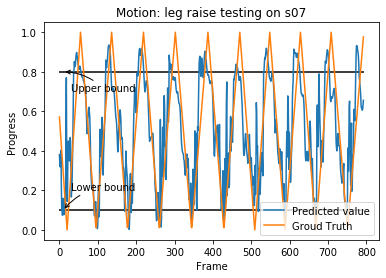

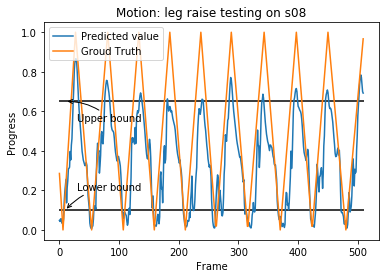

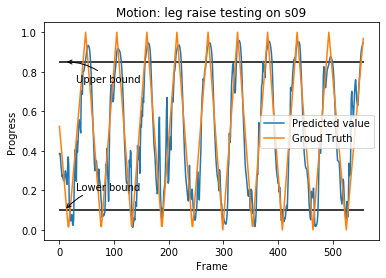

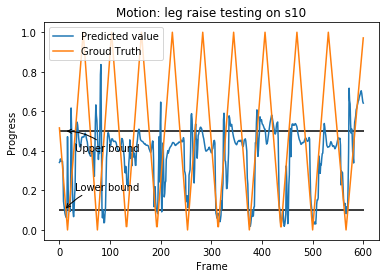

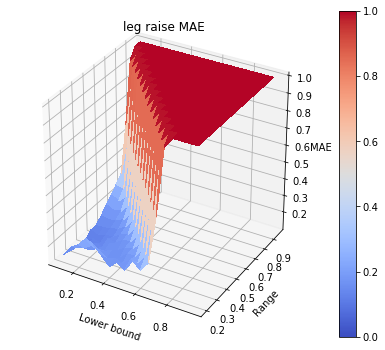

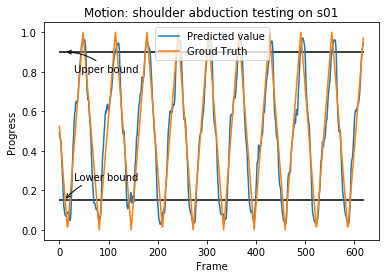

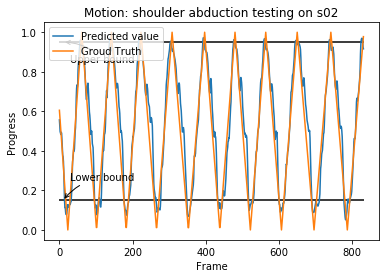

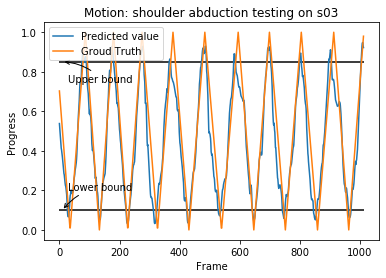

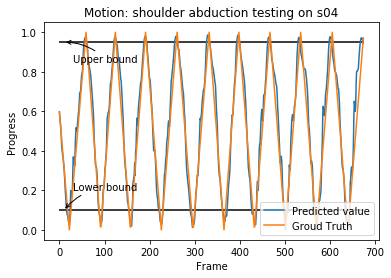

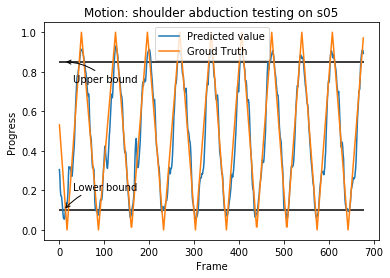

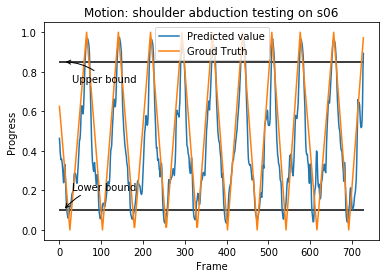

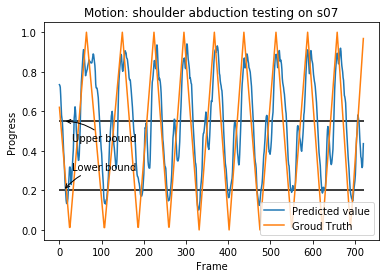

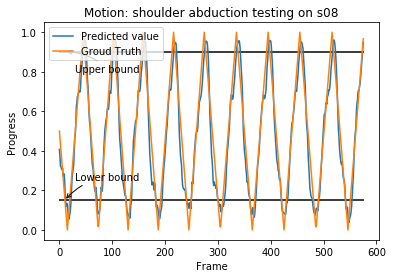

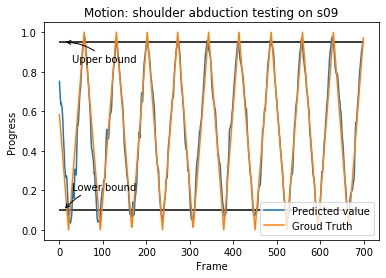

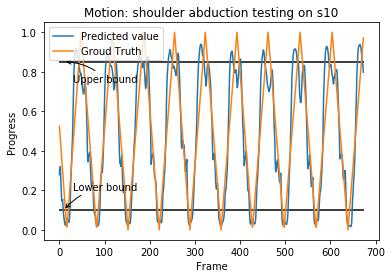

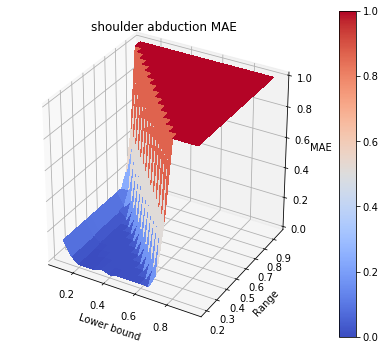

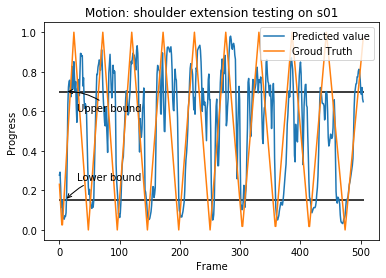

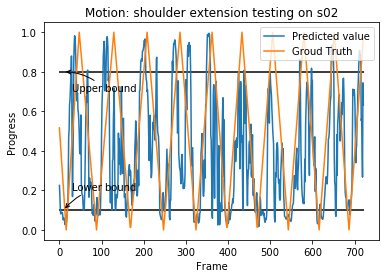

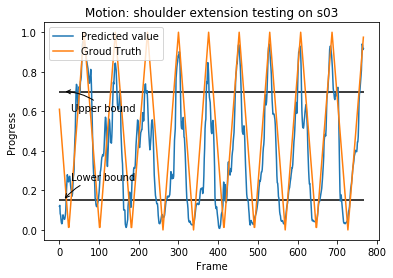

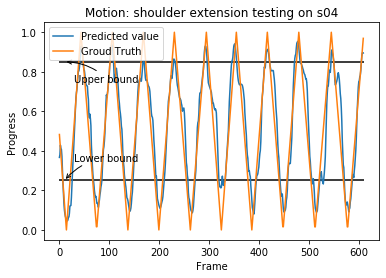

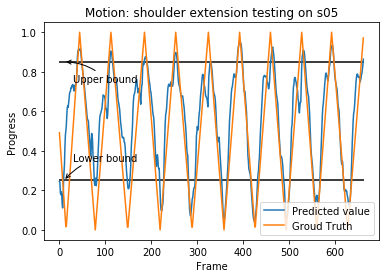

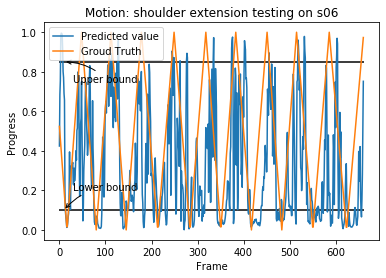

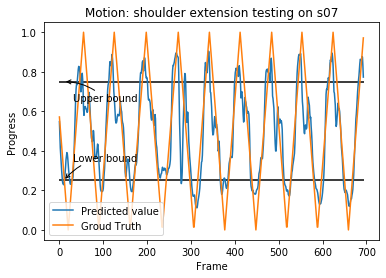

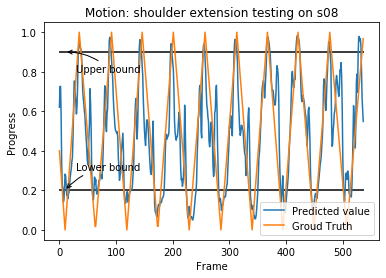

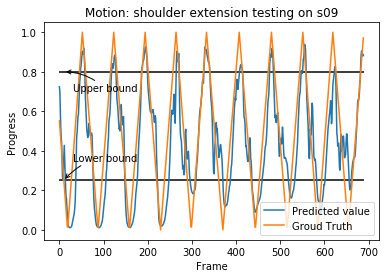

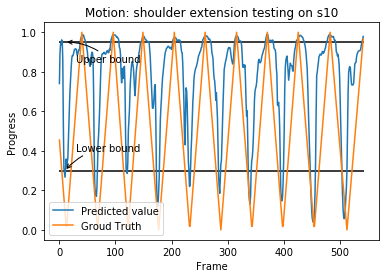

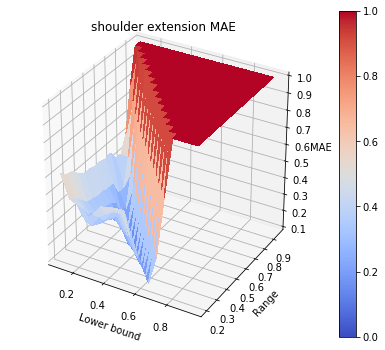

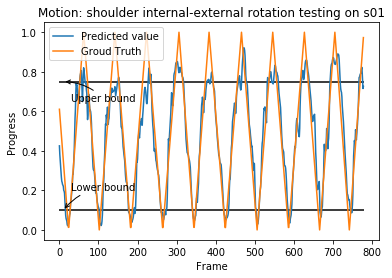

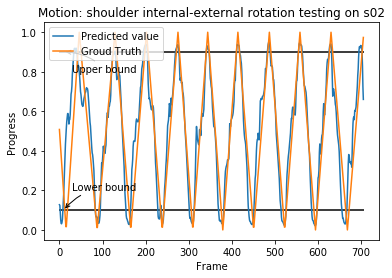

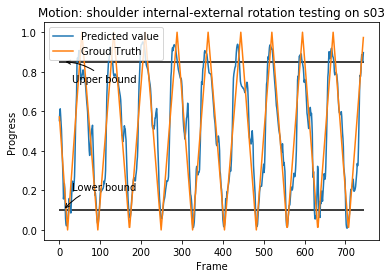

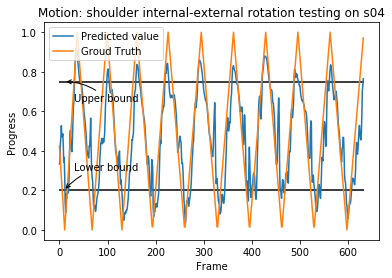

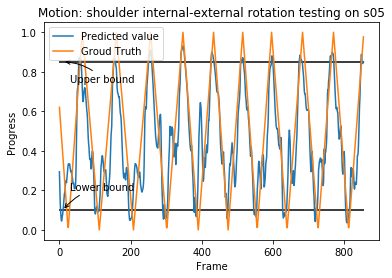

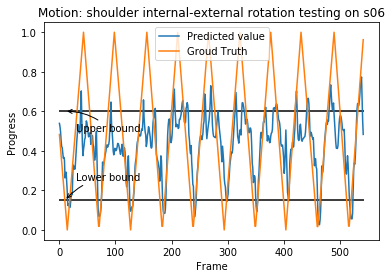

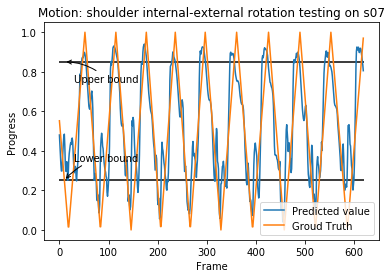

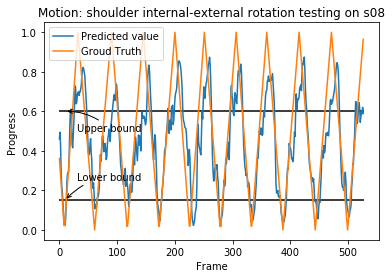

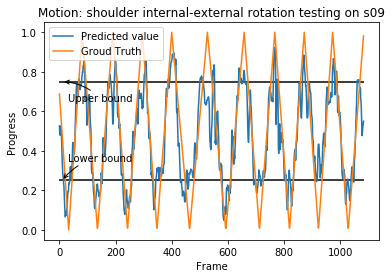

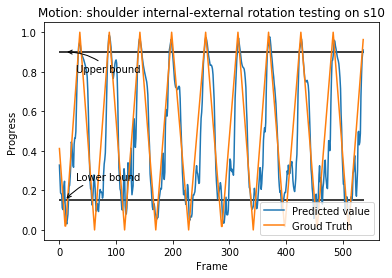

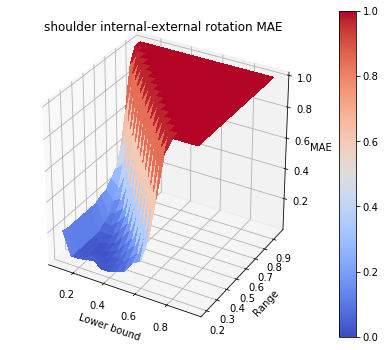

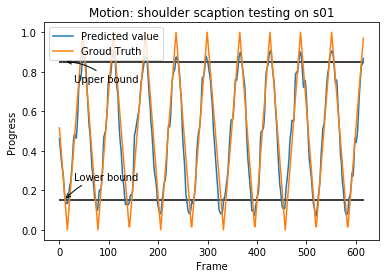

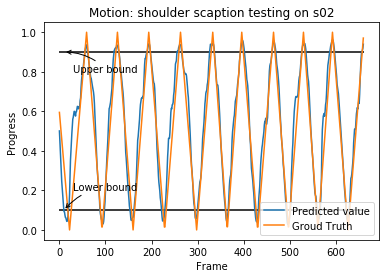

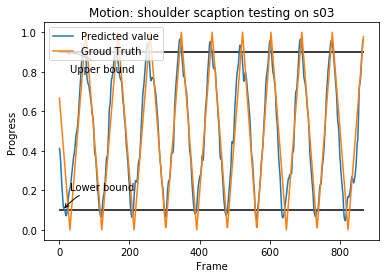

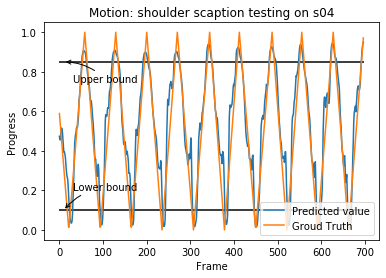

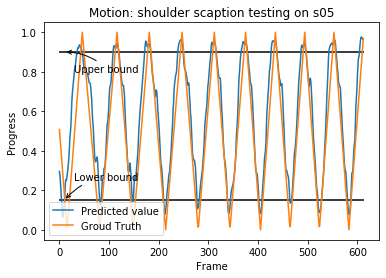

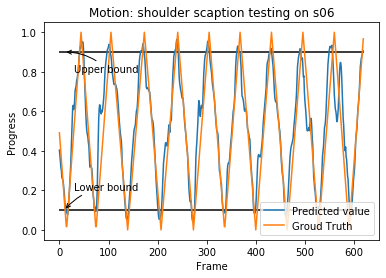

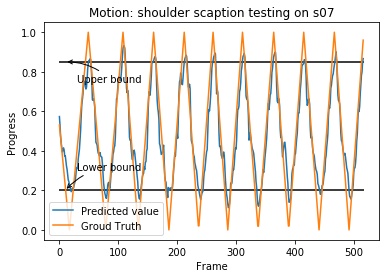

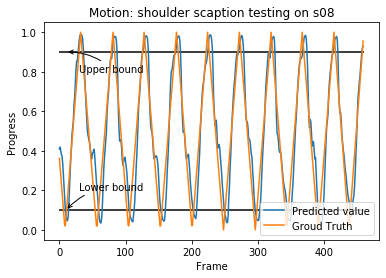

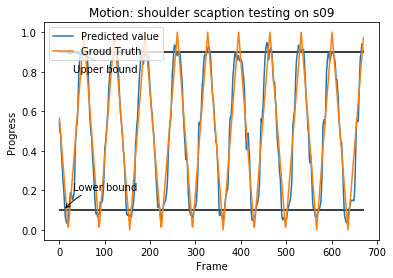

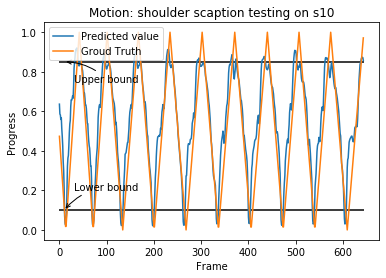

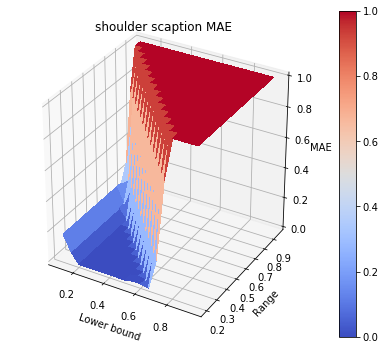

In [41]:
win_size=16
args= argparse.Namespace(name='skeleton',model_path='model/pretrained_skeleton.pth',v1='inc_deep_squat',o='inc_deep_squat',gpu_ids=0,w1=720,h1=720,transparency=False,save_frame=1,
                         fps=25,color1='#a50b69#b73b87#db9dc3',max_len=480,max_frame=480)
config.initialize(args)
mean_pose, std_pose = get_meanpose(config)
net = get_autoencoder(config)
net.load_state_dict(torch.load(args.model_path))
net.to(config.device)
net.eval()
encoder=nn.Sequential(*list(net.mot_encoder.children())[0])
perfor=pd.DataFrame(columns=task_list,index=s_number)
perfor_lb=pd.DataFrame(columns=task_list,index=s_number)
perfor_r=pd.DataFrame(columns=task_list,index=s_number)
perfor_t=pd.DataFrame(columns=task_list,index=s_number)
perfor_mse=pd.DataFrame(columns=task_list,index=s_number)
perfor_t_diff=pd.DataFrame(columns=task_list,index=s_number)
lb=np.arange(0.1,1,0.05)
bound=np.arange(0.2,1,0.05)
for task in task_list:
    m_data=np.load('data/'+task+'.npy')
    percentage=pd.read_csv('data/'+task+'.csv')
    m_data=LR_mirror(m_data,percentage,LR_table,task)
    m_data=getOpenPose(m_data)
    space=pd.DataFrame(index=lb,columns=bound)
    tot_time=0
    tot_frame=0
    for subj in s_number:
#         print("Motion: %s"%task)
#         print('Testing on subject: %s'%subj)
        X_train, y_train = np.array(m_data)[np.where(percentage['tester']!=subj),:,:][0],percentage.iloc[np.where(percentage['tester']!=subj)[0],:]
        X_test, y_test = np.array(m_data)[np.where(percentage['tester']==subj),:,:][0],percentage.iloc[np.where(percentage['tester']==subj)]
#         model=tf.keras.models.load_model('half model/0425_half_Motion_sim_poseNet_'+task+"_testing on_"+subj+'.h5')
#         model=tf.keras.models.load_model('0415_model/0415_Motion_sim_poseNet_'+task+"_testing on_"+subj+'.h5')
#         model=tf.keras.models.load_model('0415_model_no/0425_no_Motion_sim_poseNet_'+task+"_testing on_"+subj+'.h5')
        model=tf.keras.models.load_model('0516_model/0516_full_full_Motion_sim_poseNet_'+task+"_testing on_"+subj+'.h5')
#         model=tf.keras.models.load_model('0516_model/0516_half_full_Motion_sim_poseNet_'+task+"_testing on_"+subj+'.h5')

#         model=tf.keras.models.load_model('0516_model/0516_no_full_Motion_sim_poseNet_'+task+"_testing on_"+subj+'.h5')

#         X_testcamera=np.array([camera_projet(x,np.array([0,0,0.0]),np.array([0,0.0,0])) for x in X_test])
        start=time.time()
        encode_X_test_camera, sim_matrix_X_test_camera =  label_encoding(X_test, y_test,win_size,encoder)
        predict=model.predict(encode_X_test_camera)
        end=time.time()
        perfor_t[task][subj]=(end-start)/encode_X_test_camera.shape[0]
        perfor_mse[task][subj]=sk.metrics.mean_squared_error(sim_matrix_X_test_camera,predict)
        frame_time= np.where(sim_matrix_X_test_camera==1)[0]
        frame_time=np.concatenate((frame_time,[len(sim_matrix_X_test_camera)]))
        previous_best=[]
        current_frame=[]
        for l in lb:
            for ran in bound:
                if l+ran >1:
                    continue
                count=0
                low_swtich=True
                high_switch=False
                current_frame=[]
                for i in range(len(predict)):
                    if predict[i]<l and low_swtich:
                        high_switch=True
                        low_swtich=False
                    if predict[i]>l+ran and high_switch:
                        count=count+1
                        high_switch=False
                        low_swtich=True
                        current_frame.append(i)
                if space[ran][l] is np.nan:
                    space[ran][l]=np.abs(count-10)/10
#                     if count not in [9, 10, 11]:
#                         space[ran][l]=1
#                     else:
#                         space[ran][l]=0
                else:
                    space[ran][l]=np.abs(count-10)/10+space[ran][l]

#                     if count not in [9, 10, 11]:
#                         space[ran][l]=1+ space[ran][l]
#                     else:
#                         space[ran][l]=0+ space[ran][l]
                if perfor[task][subj] is np.nan or (np.abs(count-10)<np.abs(perfor[task][subj]-10)) or (np.abs(count-10)==np.abs(perfor[task][subj]-10) and ran> perfor_r[task][subj]):       
                    perfor[task][subj]= count
                    perfor_lb[task][subj]=l
                    perfor_r[task][subj]=ran
                if count ==10:
                    if previous_best == []:
                         previous_best=np.array(current_frame)
                    elif sum(np.abs(np.array(current_frame)+12-frame_time)) < sum(np.abs(np.array(previous_best)-frame_time)):
                        previous_best=np.array(current_frame)+12
        if len(previous_best) ==10:
            perfor_t_diff[task][subj]=np.mean(np.abs(np.array(previous_best)-frame_time)) 
        fig, ax= plt.subplots()
        ax.set_title("Motion: "+name_dict[task]+" testing on "+subj)
        ax.hlines([perfor_lb[task][subj],perfor_lb[task][subj]+perfor_r[task][subj]],0,len(predict))
        ax.annotate('Lower bound',(10,perfor_lb[task][subj]),xytext=(30,perfor_lb[task][subj]+0.1),arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2"))
        ax.annotate('Upper bound',(10,perfor_lb[task][subj]+perfor_r[task][subj]),xytext=(30,perfor_lb[task][subj]+perfor_r[task][subj]-0.1),arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2"))
        ax.plot(predict)
        ax.plot(sim_matrix_X_test_camera)
        ax.set_xlabel("Frame")
        ax.set_ylabel("Progress")
        ax.legend(['Predicted value','Groud Truth'])
    fig, ax= plt.subplots(subplot_kw={"projection": "3d"},figsize=(7,6))
    ax.set_title(name_dict[task]+" MAE")
    X, Y = np.meshgrid(bound,lb)
    surf = ax.plot_surface( Y,X,  np.array(space.fillna(10)/10), cmap=cm.coolwarm,
                   linewidth=0, antialiased=False)
    surf.set_clim(0,1) 
    ax.set_xlabel('Lower bound')
    ax.set_ylabel('Range')
    ax.set_zlabel('MAE')
    fig.colorbar(surf,ax=ax)

    fig.savefig('fig/motion_MAE_1_'+task)
#         ax.plot(sliding_percent)


In [ ]:
model.summary()

In [39]:
(perfor_t_diff/30).mean()

m01    0.097000
m02    0.241333
m03    0.211667
m04    0.147000
m05    0.078000
m06    0.740000
m07    0.052667
m08    0.314815
m09    0.087000
m10    0.044000
dtype: float64

In [40]:
(perfor_t_diff/30).std()

m01    0.061372
m02    0.390891
m03    0.136908
m04    0.069094
m05    0.029905
m06    1.692240
m07    0.026425
m08    0.475883
m09    0.047751
m10    0.010750
dtype: float64

In [25]:
perfor_t_diff/30

m01        m02       m03        m04        m05        m06  \
s01  0.0266667   0.103333   1.27667   0.106667  0.0833333       0.14   
s02       0.11       1.54       NaN       0.14   0.106667       0.22   
s03   0.103333       0.07  0.183333       0.13  0.0766667  0.0633333   
s04  0.0366667   0.183333  0.136667       0.05  0.0766667       0.04   
s05  0.0933333   0.306667  0.786667   0.233333  0.0733333   0.126667   
s06       0.48   0.193333      0.17   0.113333  0.0566667   0.103333   
s07        0.1       0.05  0.686667   0.116667  0.0766667   0.153333   
s08  0.0633333  0.0633333  0.276667       0.09        0.1   0.106667   
s09  0.0833333   0.103333  0.103333  0.0433333       0.11       0.07   
s10       0.12  0.0766667      0.16   0.456667  0.0466667   0.443333   

           m07        m08        m09        m10  
s01   0.113333       0.08        0.1  0.0366667  
s02       0.06    1.84333       0.09  0.0433333  
s03  0.0966667   0.103333  0.0566667       0.05  
s04       0.05  0.0366667  0.0833333       0.08  
s05  0.0233333   0.146667  0.0733333  0.0366667  
s06  0.0466667    1.88667  0.0866667  0.0366667  
s07   0.276667       0.05  0.0533333  0.0433333  
s08  0.0366667  0.0566667  0.0766667  0.0233333  
s09  0.0366667  0.0566667       0.26  0.0266667  
s10       0.07   0.113333   0.116667  0.0433333

In [27]:
perfor_t_diff/30

m01        m02        m03        m04        m05        m06  \
s01       0.02   0.153333       0.21   0.106667  0.0533333       0.18   
s02   0.136667       1.26   0.153333   0.236667       0.07   0.136667   
s03        0.1  0.0833333   0.116667   0.123333       0.07   0.223333   
s04       0.08       0.25   0.223333   0.106667       0.09  0.0266667   
s05  0.0433333   0.206667       0.18       0.36   0.133333       0.33   
s06   0.126667   0.163333       0.31   0.136667  0.0333333   0.233333   
s07  0.0566667  0.0466667       0.53   0.153333  0.0366667        NaN   
s08  0.0366667       0.15       0.16   0.106667  0.0766667        0.1   
s09       0.05        0.1  0.0733333  0.0333333   0.106667   0.106667   
s10       0.05  0.0933333   0.116667       0.44  0.0466667   0.116667   

           m07        m08        m09        m10  
s01  0.0566667  0.0766667  0.0766667  0.0266667  
s02  0.0366667       2.42  0.0666667  0.0433333  
s03        0.1   0.153333  0.0433333  0.0666667  
s04  0.0933333  0.0566667   0.176667  0.0433333  
s05  0.0266667       0.06  0.0433333  0.0366667  
s06  0.0366667    2.42667       0.08  0.0466667  
s07   0.116667  0.0433333   0.116667  0.0766667  
s08  0.0266667  0.0566667   0.106667       0.01  
s09       0.05   0.126667   0.283333       0.04  
s10  0.0233333  0.0666667  0.0566667  0.0433333

In [ ]:
perfor_t_diff/30

In [ ]:
perfor_t_diff/30

In [ ]:
perfor_t.mean(axis=0)

In [ ]:
perfor_t.mean(axis=0)

In [ ]:
perfor_mse.rename(columns=name_dict)

# OBO errror

In [ ]:
(np.abs(perfor-10)>1).mean(axis=0)

# MAE

In [ ]:
np.abs(perfor-10).mean(axis=0)

In [ ]:
perfor

In [ ]:
np.abs(perfor-10)/10

In [ ]:
perfor_r

In [ ]:
perfor_lb

In [ ]:
perfor_mse.mean(axis=1)

In [ ]:
perfor_mse.mean(axis=0)

In [ ]:
np.abs(perfor-10).mean(axis=1)

In [ ]:
np.sum(np.sum(np.abs(perfor-10)>2))

In [ ]:
np.arange(0.05,1,10)

In [ ]:
args= argparse.Namespace(name='skeleton',model_path='model/pretrained_skeleton.pth',v1='inc_deep_squat',o='inc_deep_squat',gpu_ids=0,w1=720,h1=720,transparency=False,save_frame=1,
                         fps=25,color1='#a50b69#b73b87#db9dc3',max_len=480,max_frame=480)
config.initialize(args)
mean_pose, std_pose = get_meanpose(config)
net = get_autoencoder(config)
net.load_state_dict(torch.load(args.model_path))
net.to(config.device)
net.eval()
encoder=nn.Sequential(*list(net.mot_encoder.children())[0][0:6])
win=np.ara
for task in task_list:
    
    m_data=np.load('data/'+task+'.npy')
    percentage=pd.read_csv('data/'+task+'.csv')
    m_data=LR_mirror(m_data,percentage,LR_table,task)
    m_data=getOpenPose(m_data)
    for subj in s_number:
        print("Motion: %s"%task)
        print('Testing on subject: %s'%subj)
        X_train, y_train = np.array(m_data)[np.where(percentage['tester']!=subj),:,:][0],percentage.iloc[np.where(percentage['tester']!=subj)[0],:]
        X_test, y_test = np.array(m_data)[np.where(percentage['tester']==subj),:,:][0],percentage.iloc[np.where(percentage['tester']==subj)]
        model=tf.keras.models.load_model('model/Motion_poseNet_'+task+"_testing on_"+subj+'.h5')
        
#         X_testcamera=np.array([camera_projet(x,np.array([0,0,0.0]),np.array([0,0.0,0])) for x in X_test])
        encode_X_test_camera, sim_matrix_X_test_camera =  label_encoding(X_test, y_test,win_size,encoder)
        predict=model.predict(encode_X_test_camera)
#         predict=model.predict(X_test[:,:,:2])

        count=0
        low_swtich=True
        high_switch=False
        for i in range(len(predict)):
            if predict[i]<0.3 and low_swtich:
                high_switch=True
                low_swtich=False
            if predict[i]>0.6 and high_switch:
                count=count+1
                high_switch=False
                low_swtich=True
        perfor[task][subj]=count
        fig, ax= plt.subplots()
        ax.set_title("Motion: "+task+" testing on "+subj)
        ax.plot(predict)
        ax.plot(sim_matrix_X_test_camera)
#         ax.plot(sliding_percent)


In [ ]:
np.abs(perfor-10).mean()

In [ ]:
np.abs(perfor-10).mean(axis=1)

In [ ]:
        model = keras.models.Sequential()
        model.add(keras.Input(shape=(96,3,)))
        model.add(keras.layers.LSTM(64))
#         model.add(keras.layers.Conv1D(32, 5, activation='relu'))
#         model.add(keras.layers.MaxPooling1D(2))
#         model.add(keras.layers.Conv1D(64, 3, activation='relu'))
#         model.add(keras.layers.MaxPooling1D(2))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(16))
        model.add(keras.layers.Dense(8))
        model.add(keras.layers.Dense(4))
        model.add(keras.layers.Dense(1,activation='sigmoid'))
        model.compile(
        optimizer=keras.optimizers.Adam(),
        loss="mean_squared_error",
        metrics=['MeanSquaredError']
        )
        print(model.summary())

In [ ]:
data=np.load('data/m01.npy')
percentage=pd.read_csv('data/m01.csv')
data=LR_mirror(data,percentage,LR_table,'m01')

print('Testing on subject: %s'%subj)
X_train, y_train = np.array(data)[np.where(percentage['tester']!=subj),:,:][0],percentage.iloc[np.where(percentage['tester']!=subj)[0],:]
X_test, y_test = np.array(data)[np.where(percentage['tester']==subj),:,:][0],percentage.iloc[np.where(percentage['tester']==subj)]

sliding_win, sliding_percent=get_sliding_wins(X_train, y_train,win_size)
print("train Sliding window length: %s"%len(sliding_win))
encode=[]
for i in range(len(sliding_win)):
    data=tl_preprocess_encode(sliding_win[i],encoder=encoder)
    encode.append(data)
encode=np.array(encode)


In [ ]:
encode.shape

In [ ]:
X_train, y_train =sk.utils.shuffle(encode,sliding_percent)

In [ ]:
model = keras.models.Sequential()
model.add(keras.Input(shape=(96,3,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv1D(32, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))
model.add(keras.layers.Conv1D(64, 3, activation='relu'))
model.add(keras.layers.MaxPooling1D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16))
model.add(keras.layers.Dense(8))
model.add(keras.layers.Dense(4))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile(
optimizer=keras.optimizers.Adam(),
loss="mean_squared_error",
metrics=['MeanSquaredError']
)
print(model.summary())
# model.fit(x=X_train.astype('float32'),y=y_train.astype('float32'), epochs=200,validation_split=0.2,batch_size=50)


In [ ]:
        print(model.summary())

In [ ]:
sliding_percent

In [ ]:
sliding_win, sliding_percent=get_sliding_wins(X_test, y_test,win_size)
encode=[]
for i in range(len(sliding_win)):
    data=tl_preprocess_encode(sliding_win[i],encoder=encoder)
    encode.append(data)
encode=np.array(encode)

In [ ]:
predict=model.predict(encode)
plt.plot(predict)
plt.plot(sliding_percent)

In [ ]:
subj='s01'
print('Testing on subject: %s'%subj)
X_train, y_train =sk.utils.shuffle(np.array(data)[np.where(percentage['tester']!=subj),:,:][0],np.array(percentage['percentage'])[np.where(percentage['tester']!=subj)])
X_test, y_test =sk.utils.shuffle(np.array(data)[np.where(percentage['tester']==subj),:,:][0],np.array(percentage['percentage'])[np.where(percentage['tester']==subj)])
print('X_test size: %s'%len(X_train))
print('X_test size: %s'%len(X_test))

model = keras.models.Sequential()
model.add(keras.Input(shape=(13,2,)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Conv1D(32, 3, activation='relu'))
        model.add(keras.layers.MaxPooling1D(2))
        model.add(keras.layers.Conv1D(64, 3, activation='relu'))
        model.add(keras.layers.MaxPooling1D(2))
        model.add(keras.layers.Dense(8))
        model.add(keras.layers.Dense(4))
        model.add(keras.layers.Dense(1,activation='linear'))
model.compile(
optimizer=keras.optimizers.Adam(),
loss="mean_squared_error",
metrics=['MeanSquaredError']
)
print(model.summary())
model.fit(x=X_train,y=y_train, epochs=200,validation_split=0.2,batch_size=50)
predict_result=model.predict(np.array(data)[np.where(percentage['tester']==subj),:,:][0])
test_result.append(predict_result)
fig, ax= plt.subplots()
ax.set_title("Motion: "+task+" testing on "+subj)
ax.plot(predict_result*(1/predict_result[0]))
ax.plot(np.array(percentage['percentage'])[np.where(percentage['tester']==subj)])

In [ ]:
fig, ax= plt.subplots()
ax.set_title("Motion: m01"+" testing on "+subj)
ax.plot(predict_result.squeeze())
ax.plot(np.array(percentage['percentage'])[np.where(percentage['tester']==subj)])

In [ ]:
chest=np.mean(m01[:,[2,6],:],axis=1).reshape(-1,1,3)
base=np.mean(m01[:,[9,12],:],axis=1).reshape(-1,1,3)

In [ ]:
chest.shape

In [ ]:
new_openpose=m01[:,[0],:]


In [ ]:
win_size=16
for task in task_list:

    m_data=np.load('data/'+task+'.npy')
    percentage=pd.read_csv('data/'+task+'.csv')
    m_data=LR_mirror(m_data,percentage,LR_table,task)
    m_data=getOpenPose(m_data)
    for subj in s_number:
        print("Motion: %s"%task)
        print('Testing on subject: %s'%subj)
        X_train, y_train = np.array(m_data)[np.where(percentage['tester']!=subj),:,:][0],percentage.iloc[np.where(percentage['tester']!=subj)[0],:]
        X_test, y_test = np.array(m_data)[np.where(percentage['tester']==subj),:,:][0],percentage.iloc[np.where(percentage['tester']==subj)]
        model=tf.keras.models.load_model('model_try/Model_3d/Motion_aug_'+task+"_test_on_"+subj+'.h5')

        sliding_win, sliding_percent=get_sliding_wins(X_test, y_test,win_size)
        encode_test=[]
        for i in range(len(sliding_win)):
            data=tl_preprocess_encode(sliding_win[i],encoder=encoder)
            encode_test.append(data)
        encode_test=np.array(encode_test)
        fig, ax= plt.subplots()
        ax.imshow(sk.preprocessing.MinMaxScaler().fit_transform(sk.metrics.pairwise.cosine_similarity(X_test.reshape((-1,15*3)))))
        ax.set_title("Motion: %s Testing on subject: %s"%(task,subj))

In [ ]:
win_size=12
args= argparse.Namespace(name='skeleton',model_path='model/pretrained_skeleton.pth',v1='inc_deep_squat',o='inc_deep_squat',gpu_ids=0,w1=720,h1=720,transparency=False,save_frame=1,
                         fps=25,color1='#a50b69#b73b87#db9dc3',max_len=480,max_frame=480)
config.initialize(args)
mean_pose, std_pose = get_meanpose(config)
net = get_autoencoder(config)
net.load_state_dict(torch.load(args.model_path))
net.to(config.device)
net.eval()
encoder=nn.Sequential(*list(net.mot_encoder.children())[0][0:6])
perfor=pd.DataFrame(columns=task_list,index=s_number)
perfor_lb=pd.DataFrame(columns=task_list,index=s_number)
perfor_r=pd.DataFrame(columns=task_list,index=s_number)
perfor_t=pd.DataFrame(columns=task_list,index=s_number)
perfor_mse=pd.DataFrame(columns=task_list,index=s_number)
perfor_t_diff=pd.DataFrame(columns=task_list,index=s_number)
lb=np.arange(0.1,1,0.05)
bound=np.arange(0.2,1,0.05)
for task in task_list:
    m_data=np.load('data/'+task+'.npy')
    percentage=pd.read_csv('data/'+task+'.csv')
    m_data=LR_mirror(m_data,percentage,LR_table,task)
    m_data=getOpenPose(m_data)
    space=pd.DataFrame(index=lb,columns=bound)
    tot_time=0
    tot_frame=0
    for subj in s_number:
#         print("Motion: %s"%task)
#         print('Testing on subject: %s'%subj)
        X_train, y_train = np.array(m_data)[np.where(percentage['tester']!=subj),:,:][0],percentage.iloc[np.where(percentage['tester']!=subj)[0],:]
        X_test, y_test = np.array(m_data)[np.where(percentage['tester']==subj),:,:][0],percentage.iloc[np.where(percentage['tester']==subj)]
#         model=tf.keras.models.load_model('half model/0425_half_Motion_sim_poseNet_'+task+"_testing on_"+subj+'.h5')
#         model=tf.keras.models.load_model('0415_model/0415_Motion_sim_poseNet_'+task+"_testing on_"+subj+'.h5')
        model=tf.keras.models.load_model('0415_model_no/0425_no_Motion_sim_poseNet_'+task+"_testing on_"+subj+'.h5')
#         X_testcamera=np.array([camera_projet(x,np.array([0,0,0.0]),np.array([0,0.0,0])) for x in X_test])
        start=time.time()
        encode_X_test_camera, sim_matrix_X_test_camera =  label_encoding(X_test, y_test,win_size,encoder)
        predict=model.predict(encode_X_test_camera)
        end=time.time()
        perfor_t[task][subj]=(end-start)/encode_X_test_camera.shape[0]
        perfor_mse[task][subj]=sk.metrics.mean_squared_error(sim_matrix_X_test_camera,predict)
        frame_time= np.where(sim_matrix_X_test_camera==1)[0]
        frame_time=np.concatenate((frame_time,[len(sim_matrix_X_test_camera)]))
        previous_best=[]
        current_frame=[]
        for l in lb:
            for ran in bound:
                if l+ran >1:
                    continue
                count=0
                low_swtich=True
                high_switch=False
                current_frame=[]
                for i in range(len(predict)):
                    if predict[i]<l and low_swtich:
                        high_switch=True
                        low_swtich=False
                    if predict[i]>l+ran and high_switch:
                        count=count+1
                        high_switch=False
                        low_swtich=True
                        current_frame.append(i)
                if space[ran][l] is np.nan:
                    space[ran][l]=np.abs(count-10)/10
#                     if count not in [9, 10, 11]:
#                         space[ran][l]=1
#                     else:
#                         space[ran][l]=0
                else:
                    space[ran][l]=np.abs(count-10)/10+space[ran][l]

#                     if count not in [9, 10, 11]:
#                         space[ran][l]=1+ space[ran][l]
#                     else:
#                         space[ran][l]=0+ space[ran][l]
                if perfor[task][subj] is np.nan or (np.abs(count-10)<np.abs(perfor[task][subj]-10)) or (np.abs(count-10)==np.abs(perfor[task][subj]-10) and ran> perfor_r[task][subj]):       
                    perfor[task][subj]= count
                    perfor_lb[task][subj]=l
                    perfor_r[task][subj]=ran
                if count ==10:
                    if previous_best == []:
                         previous_best=np.array(current_frame)
                    elif sum(np.abs(np.array(current_frame)+12-frame_time)) < sum(np.abs(np.array(previous_best)-frame_time)):
                        previous_best=np.array(current_frame)+12
        if len(previous_best) ==10:
            perfor_t_diff[task][subj]=np.mean(np.abs(np.array(previous_best)-frame_time)) 
        fig, ax= plt.subplots()
        ax.set_title("Motion: "+name_dict[task]+" testing on "+subj + '/n lb: ' + str(perfor_lb[task][subj]) +" r: "+str(perfor_r[task][subj]))
        ax.hlines([perfor_lb[task][subj],perfor_r[task][subj]],0,len(predict))
        ax.plot(predict)
        ax.plot(sim_matrix_X_test_camera)
#     fig, ax= plt.subplots(subplot_kw={"projection": "3d"},figsize=(7,6))
#     ax.set_title(name_dict[task]+" MAE")
#     X, Y = np.meshgrid(bound,lb)
#     surf = ax.plot_surface( Y,X,  np.array(space.fillna(10)/10), cmap=cm.coolwarm,
#                    linewidth=0, antialiased=False)
#     surf.set_clim(0,1) 
#     ax.set_ylabel('range')
#     ax.set_zlabel('MAE')
#     fig.colorbar(surf,ax=ax)

#     fig.savefig('fig/motion_MAE_1_'+task)
#         ax.plot(sliding_percent)
